# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Download the data

In [1]:
# Configuration items collected into one place
cfg = {
    # Training files directories
    'training_files_root_dir': 'train',
    'annotation_dir': 'annotations', # Sub-directory
    'images_dir': 'images', # Sub-directory
    # Other directories
    'checkpoint_dir': "./checkpoints/",
    'log_dir': "./logs/"
    }

# Constants
constants = {
    # These are possible labels defined in the dataset
    'label_titles': ["baby", "bird", "car", "clouds", "dog", "female", "flower",
                "male", "night", "people", "portrait", "river", "sea", "tree"]
}


In [2]:
import os

# Check if data files are present and obtain them if missing
if not os.path.isdir(cfg['training_files_root_dir']):
    from torchvision.datasets.utils import download_url
    import zipfile

    # Left here as not used anywhere else
    dl_file = 'dl2018-image-proj.zip'
    dl_url = 'https://users.aalto.fi/mvsjober/misc/'

    zip_path = os.path.join(cfg['training_files_root_dir'], dl_file)
    # Download data file if needed
    if not os.path.isfile(zip_path):
        download_url(dl_url + dl_file, root=cfg['training_files_root_dir'], filename=dl_file, md5=None)

    # Extract data file
    with zipfile.ZipFile(zip_path) as zip_f:
        zip_f.extractall(cfg['training_files_root_dir'])
else:
    print('Data is available')

Data is available


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

## Lets parse and take a look at the data

In [3]:
# Imports save of os, which is done earlier
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re
from skimage import io, transform
import sklearn.metrics as metrics
import time
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset


In [4]:
def create_label_matrix(annotations_dir_name):
    # Create labels for use in dataset
    labels = np.zeros((20000,14))
    
    anno_dir = os.fsencode(annotations_dir_name)
    
    for idx, file in enumerate(sorted(os.listdir(anno_dir))):
        filename = os.fsdecode(file)
        with open(os.path.join(annotations_dir_name, filename)) as f:
            lines = f.readlines()
            for line in lines:
                # Image name indexing starts from 1, so convert
                # it to matrix index by subtracting one
                img_idx = int(line)-1
                labels[img_idx, idx] = 1

    return labels


In [5]:
# Parse label data
labs = create_label_matrix(os.path.join(cfg['training_files_root_dir'],cfg['annotation_dir']))

In [6]:
# Label distributions
lab_counts = labs.sum(axis=0)
total_labs = lab_counts.sum()
sorted_indices = np.argsort(lab_counts)
labeless = (labs.sum(axis=1)==0).sum()


pad = 20
print("Class statistics\n")
print(f"{'Class':<{pad}}{'Count':<{pad}}{'% of all labels':<{pad}}{'% of all samples':<{pad}}")
for i in sorted_indices:
    print(f"{constants['label_titles'][i]:<{pad}}{int(lab_counts[i]):<{pad}}"+
          f"{lab_counts[i]/total_labs*100:.3}%{lab_counts[i]/len(labs)*100:16.3}%")
print(f"\n{'Total labels':<{pad}}{int(total_labs)}\n")
print(f"{'Samples with labels':<22} {len(labs)-labeless} ({(len(labs)-labeless)/len(labs)*100:.3}%)")
print(f"{'Samples without labels':<22} {labeless} ({labeless/len(labs)*100:.3}%)")


Class statistics

Class               Count               % of all labels     % of all samples    
baby                95                  0.47%           0.475%
river               120                 0.593%             0.6%
sea                 173                 0.855%           0.865%
car                 319                 1.58%            1.59%
bird                360                 1.78%             1.8%
dog                 448                 2.22%            2.24%
tree                525                 2.6%            2.62%
night               598                 2.96%            2.99%
flower              761                 3.76%            3.81%
clouds              1095                5.41%            5.47%
male                2979                14.7%            14.9%
portrait            3121                15.4%            15.6%
female              3227                16.0%            16.1%
people              6403                31.7%            32.0%

Total labels     

Sample can have this many labels: [0. 1. 2. 3. 4. 5.]
Sample counts by label counts from 0 to 5: [9824 4161 2388 3230  388    9]


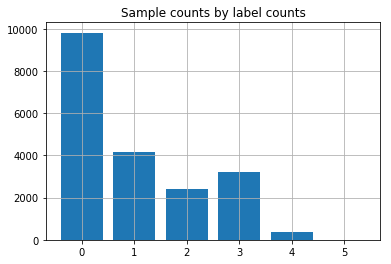

In [7]:
# How many labels per sample
bins = np.unique(labs.sum(axis=1))
print(f"Sample can have this many labels: {bins}")
counts = np.array([(labs.sum(axis=1)==u).sum() for u in bins])
print(f"Sample counts by label counts from 0 to 5: {counts}")
plt.figure()
plt.bar(bins,counts)
plt.grid()
plt.title("Sample counts by label counts")
plt.show()

Pictures with 0 labels


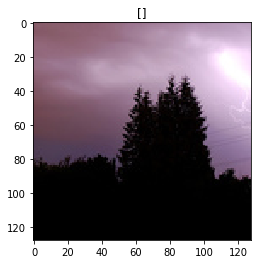

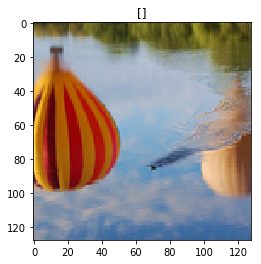

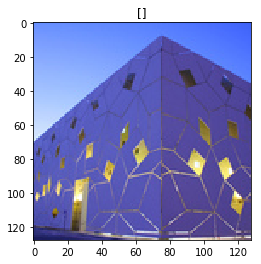

Pictures with 1 label


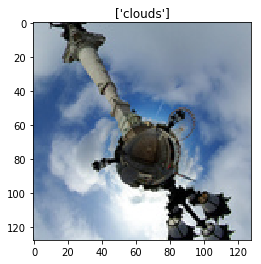

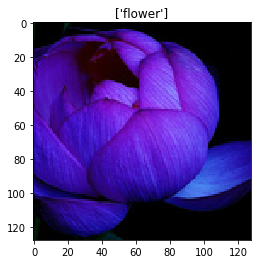

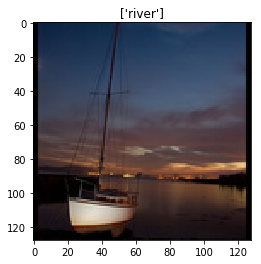

Pictures with 2 labels


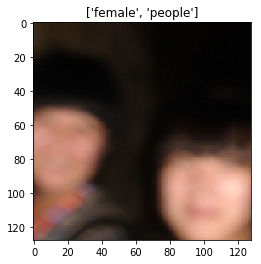

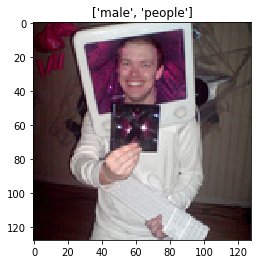

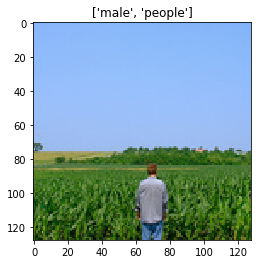

Pictures with 3 labels


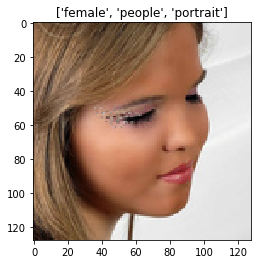

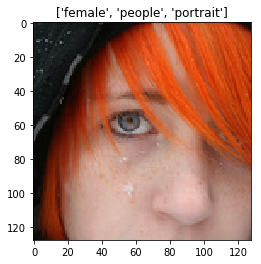

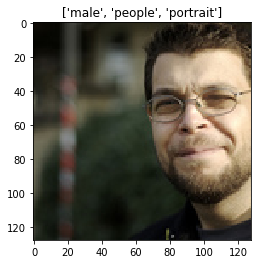

Pictures with 4 labels


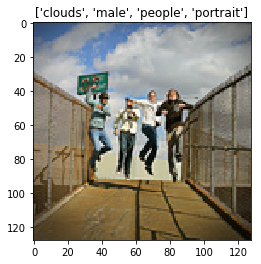

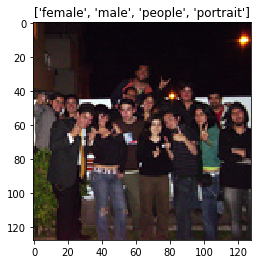

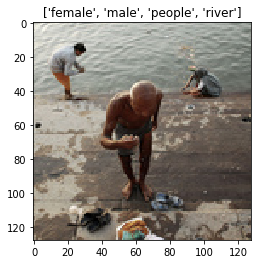

Pictures with 5 labels


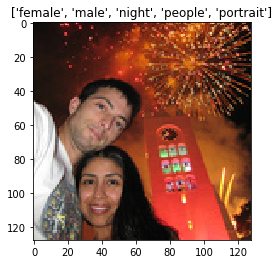

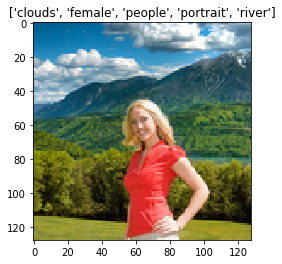

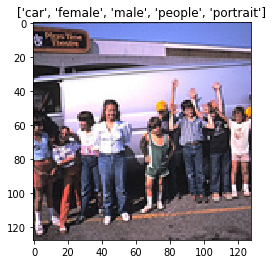

In [8]:
# Let's take a look at the pictures

# Prints pictures with exactly c labels
def picture_by_label_count(c,size=5):
    inds = np.nonzero((labs.sum(axis=1) == c).astype(int))
    inds = np.random.choice(inds[0], size=size, replace=False)
    for i in inds:
        image = Image.open(os.path.join(cfg['training_files_root_dir'],
                                        cfg['images_dir'], f"im{i+1}.jpg"))
        imlabs = [constants['label_titles'][idx] for idx,l in enumerate(labs[i,:]) if l==1]
        plt.imshow(image,label=imlabs)
        plt.title(imlabs)
        plt.show()
    return np.nonzero(inds)

# Prints pictures that have label at index c (baby=0,..., tree=13)
def picture_by_label_class(c,size=5):
    inds = np.nonzero((labs[:,c] == 1).astype(int))
    inds = np.random.choice(inds[0], size=size, replace=False)
    for i in inds:
        image = Image.open(os.path.join(cfg['training_files_root_dir'],
                                        cfg['images_dir'], f"im{i+1}.jpg"))
        imlabs = [constants['label_titles'][idx] for idx,l in enumerate(labs[i,:]) if l==1]
        plt.imshow(image,label=imlabs)
        plt.title(imlabs)
        plt.show()
    return np.nonzero(inds)

# Pictures with different amount of labels
for i in range(6):
    print(f"Pictures with {i} label{'s' if i != 1 else ''}")
    picture_by_label_count(i,3)

Pictures with label baby


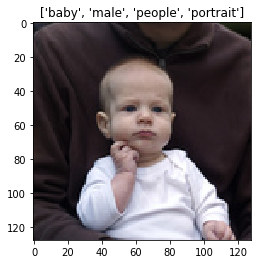

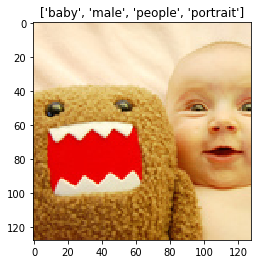

Pictures with label bird


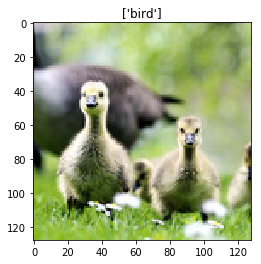

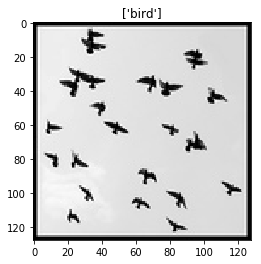

Pictures with label car


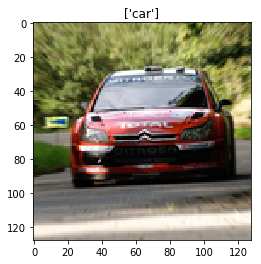

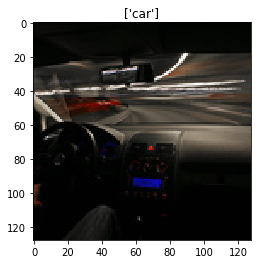

Pictures with label clouds


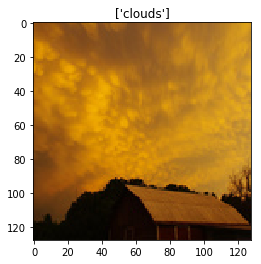

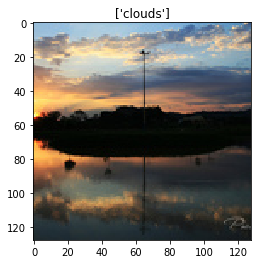

Pictures with label dog


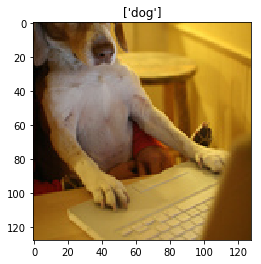

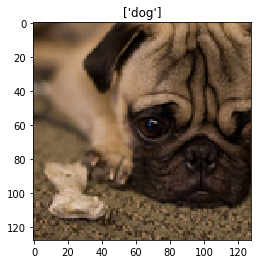

Pictures with label female


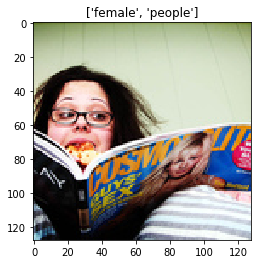

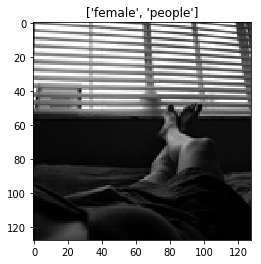

Pictures with label flower


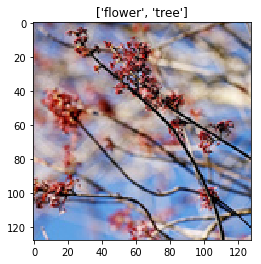

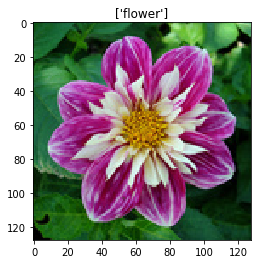

Pictures with label male


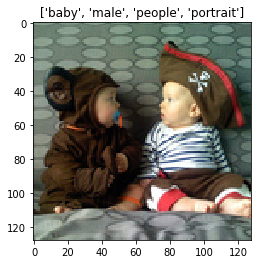

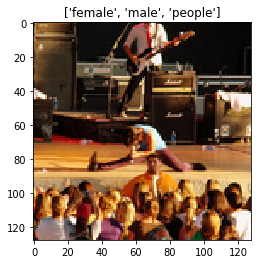

Pictures with label night


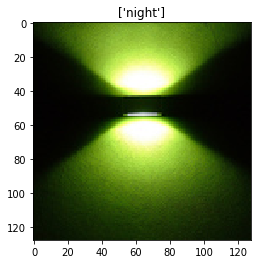

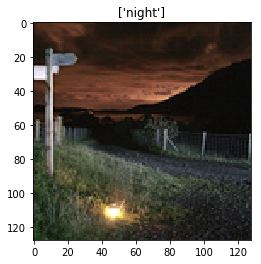

Pictures with label people


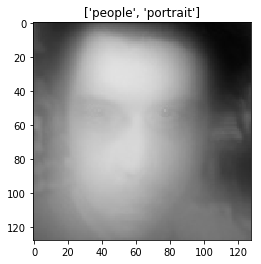

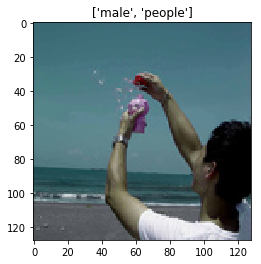

Pictures with label portrait


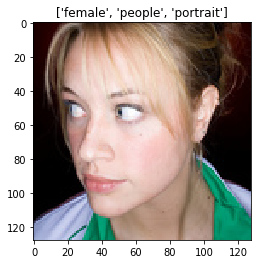

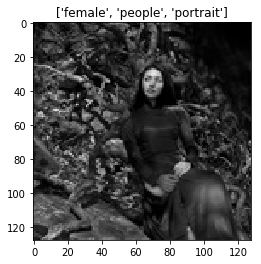

Pictures with label river


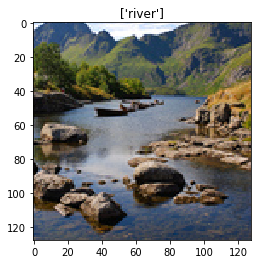

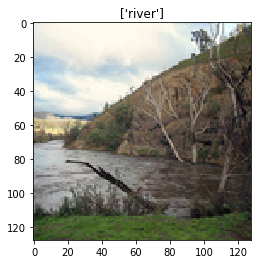

Pictures with label sea


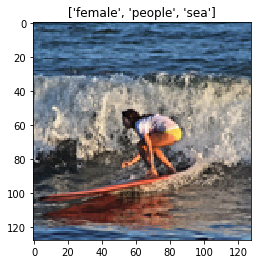

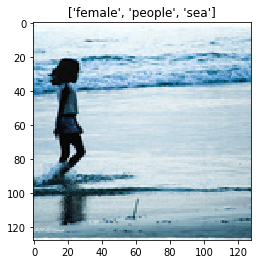

Pictures with label tree


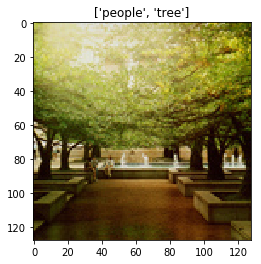

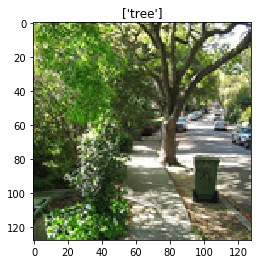

In [9]:
# Pictures with different classes
for i in range(14):
    print(f"Pictures with label {constants['label_titles'][i]}")
    picture_by_label_class(i,2)

In [10]:
# Label relations
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder


graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

edge_map = graph_builder.transform(labs)
print("{} labels, {} edges".format(len(constants['label_titles']), len(edge_map)))
print(edge_map)

14 labels, 70 edges
{(5, 9): 3166.0, (5, 10): 1946.0, (9, 10): 3121.0, (7, 9): 2928.0, (3, 13): 48.0, (8, 9): 78.0, (5, 7): 581.0, (7, 10): 1327.0, (1, 7): 8.0, (1, 9): 15.0, (5, 12): 15.0, (9, 12): 57.0, (3, 5): 31.0, (3, 9): 139.0, (0, 9): 94.0, (5, 8): 11.0, (3, 7): 60.0, (3, 12): 42.0, (7, 12): 30.0, (0, 10): 80.0, (7, 13): 15.0, (9, 13): 45.0, (0, 7): 43.0, (3, 11): 28.0, (1, 13): 16.0, (7, 8): 32.0, (3, 6): 6.0, (8, 13): 23.0, (3, 8): 17.0, (4, 9): 54.0, (0, 5): 23.0, (3, 10): 17.0, (5, 11): 4.0, (9, 11): 14.0, (10, 11): 3.0, (2, 5): 13.0, (2, 7): 20.0, (2, 9): 42.0, (2, 10): 4.0, (8, 10): 10.0, (6, 7): 9.0, (6, 9): 29.0, (6, 10): 18.0, (2, 8): 11.0, (1, 5): 8.0, (11, 13): 13.0, (5, 6): 26.0, (2, 3): 14.0, (2, 12): 1.0, (1, 3): 8.0, (4, 5): 23.0, (6, 13): 25.0, (2, 13): 1.0, (5, 13): 12.0, (4, 7): 27.0, (4, 10): 21.0, (10, 13): 3.0, (3, 4): 2.0, (1, 12): 3.0, (4, 13): 2.0, (4, 12): 2.0, (2, 4): 2.0, (7, 11): 8.0, (11, 12): 1.0, (12, 13): 5.0, (1, 6): 3.0, (1, 10): 5.0, (8, 11): 3

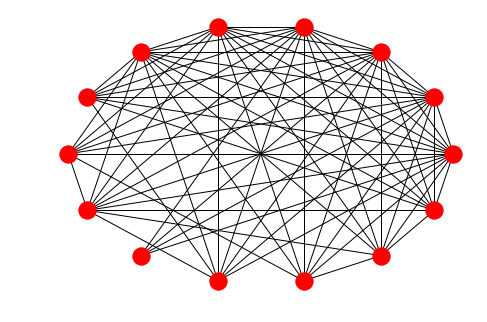

In [32]:
import networkx as nx
G = nx.Graph()

weighted_edges = []
for item in edge_map:
    weighted_edges.append((*item,edge_map[item]))

G.add_weighted_edges_from(weighted_edges)
nx.draw_circular(G)

## Data manipulation

In [ ]:
# Dataset class for easy access to data
class ImageDataset(Dataset):
    def __init__(self, index_map, transformations, labels, root_dir):
        self.index_map = index_map # Contenst in tuple (image number zero based, index to transformations array)
        self.labels = labels
        self.transformations = transformations # Array of transformations
        self.root_dir = root_dir

    def __getitem__(self, index):
        # Separated image number and transformation index
        img_idx, trans_idx = self.index_map[index]
        # Image filenames start with 1
        filename = f"im{img_idx + 1}.jpg"
        # Read the image in PIL format for it to work with transformations
        image = Image.open(os.path.join(self.root_dir, filename))
        imglabels = self.labels[img_idx]
        # Apply necessary transformations
        image = self.transformations[trans_idx](image)
        
        # This takes the V value from HSV transformation i.e. does color to grayscale transformation
        image = torch.max(image, dim=0)[0].unsqueeze(dim=0)

        return (image, imglabels)

    def __len__(self):
        return len(self.index_map)


In [ ]:
# Combine image and transformation indices into combined array, so that all different
# transformations are done to image
def combine_index_and_transform(indices, trnsfrms):
    cidx = []
    for tr in range(len(trnsfrms)):
        for idx in indices:
            cidx.append((idx, tr))
    return cidx


In [ ]:
# Storage for various sets related items
class TVTClass:
    size = 0 # Set size
    indices = [] # Image indices for this set
    transforms = 0 # Array of transformations for these images
    index_transform_map = [] # Tuple array of combine_index_and_transform result
    img_set = 0 # Dataset class instace
    loader = 0 # Dataloader class instance


In [ ]:
# Here we create iterators for training and validation datasets

# BATCH_SIZE is obvious
# TRAIN_SPLIT tells how big portion of data stays in
# the training set
BATCH_SIZE = 64
TRAIN_SPLIT = 0.75

labels = create_label_matrix(os.path.join(cfg['training_files_root_dir'],cfg['annotation_dir']))

ctrain = TVTClass()
cvalidation = TVTClass()

# Create array of indices and split them into two sets - training and validation
# NOTE: This is simple way to include all images. To change that e.g. for downsampling
# or upsampling TVTClass.indices (the last line below where those two indices are set)
# is the key, so changing these indices creation will achieve wanted result.
image_indices = list(range(len(labels)))
ctrain.size = int(TRAIN_SPLIT * len(image_indices))
cvalidation.size = len(image_indices) - ctrain.size
# Randomize what goes into what set
all_indices = np.random.permutation(image_indices)
ctrain.indices, cvalidation.indices = all_indices[:ctrain.size], all_indices[ctrain.size:]

# Here are the transforms that are applied to the images
# Images must be transformed at least to tensor, grayscale conversion is done inside dataset class

# Training data related transformations
ctrain.transforms = [transforms.Compose([transforms.ToTensor()]),
           transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])]
ctrain.index_transform_map = combine_index_and_transform(ctrain.indices, ctrain.transforms)

# Validation data related transformations
# Typically nothing else than to tensor
cvalidation.transforms = [transforms.Compose([transforms.ToTensor()])]
cvalidation.index_transform_map = combine_index_and_transform(cvalidation.indices, cvalidation.transforms)

# Create datasets for training and validation
ctrain.img_set = ImageDataset(ctrain.index_transform_map, ctrain.transforms, labels,
                             os.path.join(cfg['training_files_root_dir'],cfg['images_dir']))
cvalidation.img_set = ImageDataset(cvalidation.index_transform_map, cvalidation.transforms, labels,
                                  os.path.join(cfg['training_files_root_dir'],cfg['images_dir']))

# Create dataloaders for training and validation
ctrain.loader = torch.utils.data.DataLoader(dataset=ctrain.img_set, batch_size=BATCH_SIZE,
                                           shuffle=False)
cvalidation.loader = torch.utils.data.DataLoader(dataset=cvalidation.img_set,batch_size=BATCH_SIZE,
                                                shuffle=False)


In [ ]:
# Some statisctics about dataset
for i in range(len(constants['label_titles'])):
    print(constants['label_titles'][i],": ",int(label_counts[i]))

labeled = 0
one_label = 0
for i in range(labels.shape[0]):
    if labels[i].sum() > 0:
        labeled += 1
    if labels[i].sum() == 1:
        one_label += 1

print("Total labels: ", int(label_counts.sum()))
print("Samples that have labels: ", labeled, " which is ", (labeled/20000)*100, "% of total samples")
print(one_label)

In [ ]:
# Check out what one batch has
for idx, (image,label) in enumerate(ctrain.loader):
    for i in range(image.shape[0]):
        s = []
        for j in range(len(label[0])):
            if int(label[i,j]) == 1:
                s.append(constants['label_titles'][j])
        plt.title(s)
        plt.imshow(image[i].squeeze(),cmap="gray",label=s)
        plt.show()
    break

In [ ]:
# Check out what one batch has
for idx, (image,label) in enumerate(cvalidation.loader):
    for i in range(image.shape[0]):
        s = []
        for j in range(len(label[0])):
            if int(label[i,j]) == 1:
                s.append(constants['label_titles'][j])
        plt.title(s)
        plt.imshow(image[i].squeeze(),cmap="gray",label=s)
        plt.show()
    break

## Functions for defining and training the model

In [ ]:
"""
Multilabeling images

Template for the network training procedure, which includes logging in the middle of training epochs,
logging each epoch losses and accuracies to a separate file, and saving network and optimizer parameters
to a separate file.
"""

#Hardware detection
if torch.cuda.is_available():
    print('Using GPU.')
    device = torch.device('cuda')
else:
    print('Using CPU.')
    device = torch.device('cpu')

def batch_accuracy(preds, y):
    """Count accuracy for given batch
    Parameters:
       preds - values predicted by the model
       y - target values
    Returns:
       Amount of correct answers normalized ie value between 0.0 and 1.0
    """
    
    # Need to copy to CPU when using GPU
    pred = preds.cpu()
    target = y.cpu()
    
    # Naive thresholding, if value at least 0.5 label is predicted as true
    pred = pred.round()
    
    # Exact Match Ratio
    # Prediction is correct only if all labels for the sample are correct
    return (pred.eq(target).sum(dim=1)==14).float().mean()

def threshold(z):
    return np.round(z)

def train(model, iterator, optimizer, criterion, logPerInterval=0.25):
    """Training method
    Parameters:
        model - Used neural net
        iterator - Iterator for training data
        optimizer - Used optimizer
        criterion - Used loss function
        logPerInterval - Fraction of epoch at which time intermediate logs are printed to output,
                         in case one epoch takes too long. Set to zero to make no such logs.
    Returns:
        Training loss
        Training accuracy
    """
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for count, (data, target) in enumerate(iterator):
        data = data.to(device)
        target = target.float().to(device)
        
        optimizer.zero_grad()
        predictions = model(data)
        
        loss = criterion(predictions, target)
        acc = batch_accuracy(predictions, target)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
            
        progress = count / len(iterator)
        if logPerInterval > 0 and count > 0 and count % (int(len(iterator) * logPerInterval)) == 0:
            print(f'    {progress*100:.2f}%: Loss: {epoch_loss/count:.3f}, Acc: {epoch_acc*100/count:.2f}%')
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, return_preds=False):
    """Evaluation method, used for both validation and test sets
    Parameters:
        model - Used neural net
        iterator - Iterator for training data
        criterion - Used loss function
    Returns:
        Loss
        Accuracy
    """

    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    preds = np.zeros((len(iterator)*iterator.batch_size,14))
    targets = np.zeros((len(iterator)*iterator.batch_size,14))
    prev = 0
    with torch.no_grad():
        for idx, (data,target) in enumerate(iterator,1):
            data = data.to(device)
            target = target.float().to(device)
            predictions = model(data)
            
            # Save the predictions and true labels
            # for further use
            cur_end = len(predictions) + prev
            preds[prev:cur_end,:] = predictions
            targets[prev:cur_end,:] = target
            prev = cur_end
            
            
            loss = criterion(predictions, target)
            acc = batch_accuracy(predictions, target)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    print("F1 score for validation set: ", 
          metrics.f1_score(targets,threshold(preds),average="micro"))
    if return_preds:
        return epoch_loss / len(iterator), epoch_acc / len(iterator), (preds, target)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def saveCheckpoint(epoch, model, optimizer, filename):
    """Saves checkpoint to external file
    Parameters:
        epoch - Current epoch
        model - Neural net, whose parameters are saved
        optimizer - Optimizer state to save
        filename - Name of the checkpoint file
    """
    
    states = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(states, filename)

In [ ]:
class Net(nn.Module):
    """ Neural network used for this project """
    def __init__(self, dropout):  #TODO: Have more hyperparameters as arguments
        super().__init__()
        
        # Trivial CNN just for testing that everything works
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=3)
        
        # 14 classes
        self.last = nn.Linear(16*42*42, 14)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = x.view(-1, 16*42*42)
        # Sigmoid to make all values between 0 and 1
        x = torch.sigmoid(self.last(x))
        return x

In [ ]:
#Obviously savepaths would be different among us developers,
#but I suggest timestamping and naming models to preserve backups
filePrefix = "net01"
timestampToLoad = "20181212-171605-1"
loadModel = False    #If set to true, will load checkpoint from 'checkpointPath/filePrefix-timestampToLoad.cpt'

saveInterval = 5    #Save the model after this amount of epochs
checkPointRotation = 3    #Amount of checkpoints to rotate over one session

#Define hyperparameters here (layer widths, dropout etc)
DROPOUT = 0.5
N_EPOCHS = 1     #Amount of epochs per session

model = Net(DROPOUT)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
criterion = nn.BCELoss()

#I'm assuming all of us are using GPUs, in which case this serialization should work.
#If you are switching to CPU, some extra steps are needed, so refer to: https://pytorch.org/tutorials/beginner/saving_loading_models.html
checkPoint = None
if loadModel:
    checkPoint = torch.load("{}{}-{}.cpt".format(cfg['checkpoint_dir'], filePrefix, timestampToLoad))
    model.load_state_dict(checkPoint['model'])
    optimizer.load_state_dict(checkPoint['optimizer'])
    #Following needs to be reconsidered if not using GPU (comment out maybe?)
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

model = model.to(device)
criterion = criterion.to(device)

#train_loader = train_loader
#valid_loader = validation_loader
#test_loader = ...

startEpoch = 0
if loadModel:
    startEpoch = checkPoint['epoch']
saveCount = 0
#Lock in starting datetime as part of filename for this session
timestampToSave = "{}".format(time.strftime("%Y%m%d-%H%M%S"))

train_losses = []
valid_losses = []

for epoch in range(startEpoch, startEpoch + N_EPOCHS):
    train_loss, train_acc = train(model, ctrain.loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, cvalidation.loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    #Log loss and accuracy in case we want to draw graphs
    #Each session creates new log file. If you want to append to existing log file, just remove the timestamp part from the end of filename.
    with open("{}{}-{}.txt".format(cfg['log_dir'], filePrefix, timestampToSave), 'a') as logFile:
        logFile.write("{} {} {} {} {}\n".format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))

    #Save model
    if epoch % saveInterval == 0:
        saveCheckpoint(epoch, model, optimizer, "{}{}-{}-{}.cpt".format(cfg['checkpoint_dir'], filePrefix, timestampToSave, saveCount % checkPointRotation))
        saveCount += 1
            
#Save one last time at the end of execution
saveCheckpoint(epoch, model, optimizer, "{}{}-{}-{}.cpt".format(cfg['checkpoint_dir'], filePrefix, timestampToSave, saveCount % checkPointRotation))

#Draw plots (only plots current session, there's another script to plot what was written to log)
plt.plot(np.arange(startEpoch+1,startEpoch + N_EPOCHS+1), train_losses, label='Training loss')
plt.plot(np.arange(startEpoch+1,startEpoch + N_EPOCHS+1), valid_losses, label='Validation loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Loads a model
# Needs a model of same structure as parameter
def load_model(model, optimizer, timestampToLoad, checkpointPath = "./checkpoints/"):  
    checkPoint = torch.load("{}{}-{}.cpt".format(checkpointPath, filePrefix, timestampToLoad))
    epoch = checkPoint['epoch']
    model.load_state_dict(checkPoint['model'])
    optimizer.load_state_dict(checkPoint['optimizer'])
    # Following needs to be reconsidered if not using GPU (comment out maybe?)
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()    
    
    return model, optimizer, epoch

# Used to do both training and evaluation of the model
# If save_results is False, doesn't save logs or checkpoints, mainly for Colab
def train_and_evaluate(model, train_loader, validation_loader, n_epochs, startEpoch=0,
                       save_results=True,  saveInterval = 5, checkPointRotation = 3,
                       filePrefix="net01", checkpointPath = "./checkpoints/",
                       logPath = "./logs/"):
    
    saveCount = 0
    # Lock in starting datetime as part of filename for this session
    timestampToSave = "{}".format(time.strftime("%Y%m%d-%H%M%S"))

    for epoch in range(startEpoch, startEpoch + n_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, validation_loader, criterion)
        print(f"| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | "+
              f"Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |")
        # Log loss and accuracy in case we want to draw graphs
        # Each session creates new log file. If you want to append to existing log file,
        # just remove the timestamp part from the end of filename.
        if save_results:
            with open("{}{}-{}.txt".format(logPath, filePrefix, timestampToSave), 'a') as logFile:
                logFile.write("{} {} {} {} {}\n".format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))

            #Save model
            if epoch % saveInterval == 0:
                saveCheckpoint(epoch, model, optimizer, "{}{}-{}-{}.cpt".format(
                    checkpointPath, filePrefix, timestampToSave, saveCount % checkPointRotation))
                saveCount += 1

    #Save one last time at the end of execution
    if save_results:
        saveCheckpoint(epoch, model, optimizer, 
                       "{}{}-{}-{}.cpt".format(checkpointPath, filePrefix, timestampToSave, saveCount % checkPointRotation))    


In [ ]:
# 1. Create dataset and loaders
#
# 2. Create or load the network
#
# 3. Train and evaluate it

#Obviously savepaths would be different among us developers,
#but I suggest timestamping and naming models to preserve backups
#CHKPNT_PTH = "./checkpoints/"
#LOG_PTH = "./logs/"

N_EPOCHS = 1

#train_loader = train_loader
#validation_loader = validation_loader

params = [0.0,0.5,0.99]

for idx,param in enumerate(params):
    filePrefix = f"test_pi{idx}"
    model = Net(dropout = param).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    train_and_evaluate(model, ctrain.loader, cvalidation.loader, N_EPOCHS, filePrefix=filePrefix)


## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')